<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [3]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [2]:
!python -m spacy download en_core_web_lg -q

2022-11-04 14:27:21.544258: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 14 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [6]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [7]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [8]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [11]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)
#patterns: List[str]


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [13]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [14]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20220930.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [16]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,60,61,62
DSI_Title,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Text,"The sleepy, dopey action bonanza Angel Has Fa...",Angel Has Fallen marks the third time that G...,In 2013 audiences were first introduced to Sec...
Submission File Name,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Student Name,KLD,KLD,KLD
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_60,Action_Angel Has Fallen_N_61,Action_Angel Has Fallen_N_62
Doc_ID,60,61,62
raw_sentences,"[The sleepy, dopey action bonanza Angel Has F...",[ Angel Has Fallen marks the third time that ...,[In 2013 audiences were first introduced to Se...


## Tokenize Words

In [17]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
60    [sleepy, dopey, action, bonanza, angel, fallen...
61    [angel, fallen, mark, time, gerard, butler, se...
62    [audience, introduce, secret, service, agent, ...
63    [hear, phrase, glutton, punishment, course, ca...
64    [fallen, trilogy, feature, exploit, secret, se...
Name: lemmas, dtype: object

In [18]:
corpus_df.head(3).T

Doc_ID,60,61,62
DSI_Title,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Text,"The sleepy, dopey action bonanza Angel Has Fa...",Angel Has Fallen marks the third time that G...,In 2013 audiences were first introduced to Sec...
Submission File Name,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Student Name,KLD,KLD,KLD
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_60,Action_Angel Has Fallen_N_61,Action_Angel Has Fallen_N_62
Doc_ID,60,61,62
raw_sentences,"[The sleepy, dopey action bonanza Angel Has F...",[ Angel Has Fallen marks the third time that ...,[In 2013 audiences were first introduced to Se...


## Reassemble Leminized Words

In [19]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [20]:
corpus_df['lemmas_joined'].head()

Doc_ID
60    sleepy dopey action bonanza angel fallen disap...
61    angel fallen mark time gerard butler secret se...
62    audience introduce secret service agent mike b...
63    hear phrase glutton punishment course case oxf...
64    fallen trilogy feature exploit secret service ...
Name: lemmas_joined, dtype: object

In [21]:
corpus_df.head(3).T

Doc_ID,60,61,62
DSI_Title,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Text,"The sleepy, dopey action bonanza Angel Has Fa...",Angel Has Fallen marks the third time that G...,In 2013 audiences were first introduced to Sec...
Submission File Name,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Student Name,KLD,KLD,KLD
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_60,Action_Angel Has Fallen_N_61,Action_Angel Has Fallen_N_62
Doc_ID,60,61,62
raw_sentences,"[The sleepy, dopey action bonanza Angel Has F...",[ Angel Has Fallen marks the third time that ...,[In 2013 audiences were first introduced to Se...


## Vocabulary Data Wrangling

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 12344
Curated Vocabulary size: 3021


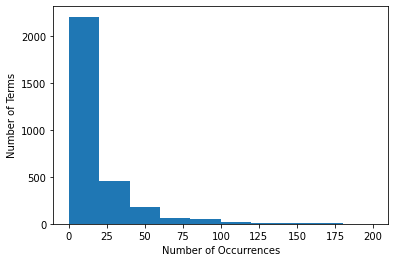

In [23]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [24]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
60    [action, angel, fallen, disappointing, reason,...
61    [angel, fallen, mark, time, gerard, butler, se...
62    [audience, introduce, secret, service, agent, ...
63    [hear, phrase, course, case, define, person, e...
64    [fallen, trilogy, feature, exploit, secret, se...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words 

In [25]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [26]:
corpus_df.head().T

Doc_ID,60,61,62,63,64
DSI_Title,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen,KLD_Doc4_AngelHasFallen,KLD_Doc5_AngelHasFallen
Text,"The sleepy, dopey action bonanza Angel Has Fa...",Angel Has Fallen marks the third time that G...,In 2013 audiences were first introduced to Sec...,Ever heard of the phrase a glutton for punish...,And here is part three of the Fallen trilogy...
Submission File Name,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen,KLD_Doc4_AngelHasFallen,KLD_Doc5_AngelHasFallen
Student Name,KLD,KLD,KLD,KLD,KLD
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_60,Action_Angel Has Fallen_N_61,Action_Angel Has Fallen_N_62,Action_Angel Has Fallen_N_63,Action_Angel Has Fallen_N_64
Doc_ID,60,61,62,63,64
raw_sentences,"[The sleepy, dopey action bonanza Angel Has F...",[ Angel Has Fallen marks the third time that ...,[In 2013 audiences were first introduced to Se...,[Ever heard of the phrase a glutton for punis...,[And here is part three of the Fallen trilog...


## Review Documents By Movie Title

In [27]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No time to die' 'Taken' 'The Revenant'
 'The Toxic Avenger' 'DespicableMe3' 'Dirty Grandpa' 'Happy Gilmore'
 'Legally Blonde' 'The Lost City' 'Drag me to hell' 'Fresh'
 'It Chapter Two' 'Us' 'Equilibrium' 'Minority Report' 'Oblivion'
 'Pitch Black' 'The Batman']


In [28]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Angel Has Fallen'].copy()
movie_df.head(3).T

Doc_ID,60,61,62
DSI_Title,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Text,"The sleepy, dopey action bonanza Angel Has Fa...",Angel Has Fallen marks the third time that G...,In 2013 audiences were first introduced to Sec...
Submission File Name,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen
Student Name,KLD,KLD,KLD
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_60,Action_Angel Has Fallen_N_61,Action_Angel Has Fallen_N_62
Doc_ID,60,61,62
raw_sentences,"[The sleepy, dopey action bonanza Angel Has F...",[ Angel Has Fallen marks the third time that ...,[In 2013 audiences were first introduced to Se...


## Knowledge Graph Extraction

In [ ]:
#corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
corpus_text_sentences = [y for x in movie_df.sentences_lemmatized for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'olympus fallen credible wet dream'

In [ ]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 407/407 [00:02<00:00, 174.11it/s]


In [ ]:
entity_pairs

[['disappointing  reason', ''],
 ['fallen  angel', 'high  bar'],
 ['olympus', 'fallen number revenge fantasy'],
 ['basically america sake', 'trumbull morgan freeman'],
 ['', ''],
 ['olympus', 'wet  dream'],
 ['defense punch face', 'right drag floor'],
 ['banning', 'funny agent tie guy'],
 ['olympus', 'good  stop'],
 ['viewer drama', 'deep  intensity'],
 ['angel', 'american lead figure'],
 ['', 'angel fallen care predecessor'],
 ['', 'estranged  dad'],
 ['', 'good look scott photography'],
 ['', ''],
 ['maker angel', 'fallen know ride desk'],
 ['version', 'john good day'],
 ['action equivalent', ''],
 ['vague drone attack explosion', 'sense'],
 ['banning', 'ready rush nation case'],
 ['banning', 'moral baddie sell money'],
 ['', 'value creator scene dialogue characterization'],
 ['', 'sound design fine'],
 ['close butler freeman', 'visual smoke flash coherence'],
 ['scene', 'spoiler blow goon'],
 ['key  moment', 'great race conviction inspiration'],
 ['brow entertainment thing', 'angel 

### Create DataFrame (Source, Target, Edge)

In [ ]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [ ]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [ ]:
kg_df.head(10).T

,1,2,3,5,6,7,8,9,10,15
source,fallen angel,olympus,basically america sake,olympus,defense punch face,banning,olympus,viewer drama,angel,maker angel
target,high bar,fallen number revenge fantasy,trumbull morgan freeman,wet dream,right drag floor,funny agent tie guy,good stop,deep intensity,american lead figure,fallen know ride desk
edge,fallen high,violence,confirm,fallen credible,scream,kill,fallen good,wait,blame,struggle


In [ ]:
kg_df.shape

(182, 3)

In [ ]:
len(corpus_text_sentences)

407

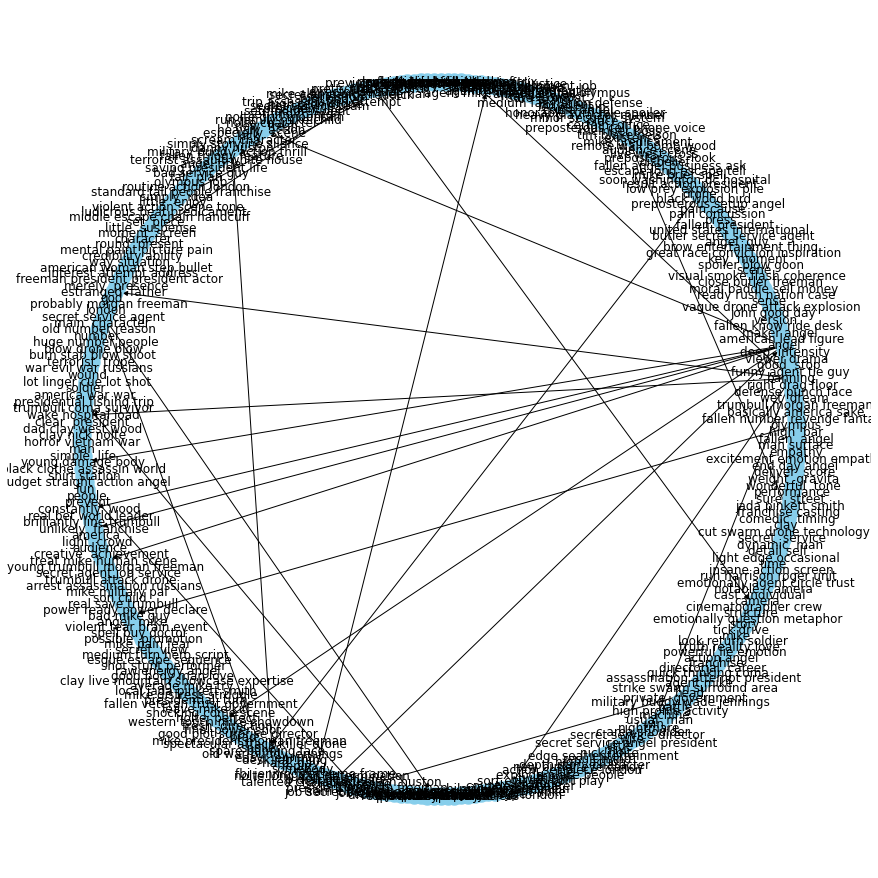

In [ ]:
plot_graph(kg_df, use_circular=True)

In [ ]:
get_top_sources_and_targets (kg_df)

[('banning', 8),
 ('angel', 8),
 ('olympus', 4),
 ('butler', 3),
 ('secret service agent', 3),
 ('drone', 2),
 ('tim blake nelson', 2),
 ('president', 2),
 ('danny huston', 2),
 ('fan', 2)]

In [ ]:
get_top_edges(kg_df)

[('fallen', 10),
 ('find', 7),
 ('kill', 4),
 ('die', 4),
 ('expect', 4),
 ('play', 4),
 ('come', 4),
 ('include', 4),
 ('want', 4),
 ('suffer', 3)]

In [ ]:
find_sources_and_targets_with_patterns(['secret service'], kg_df)

,source,target,edge
27,butler secret service agent,united states international,expect
113,secret service team,president life,include secret
157,london,secret service agent,promote
238,secret service agent,spoiler,die
268,job secret service agent president,job director agency,begin
273,secret service agent,alive run innocence,stay alive
283,gerard butler,secret service agent mike,portray secret
304,little,secret service angel president,save
305,wife,secret service director,push


In [ ]:
pd.Series(relations).value_counts()[:50]

fallen         17
banning        14
find            7
come            6
expect          5
kill            5
die             4
want            4
play            4
include         4
bring           4
suffer          3
president       3
set             3
feel            3
tell            3
seek            3
thank           3
start           2
understand      2
jennings        2
save            2
clich           2
enter           2
pull            2
huston          2
absolutely      2
love            2
try             2
crack           2
appear          2
like            2
speak           2
buy             2
accuse          2
plot            2
count           2
blame           2
sign            2
shoot           2
title           2
fallen good     2
ask             2
run             2
miss            2
butler          2
editing         2
feel like       2
need            2
believe         2
dtype: int64

In [ ]:
RELATION_TO_EXPLORE = 'find'

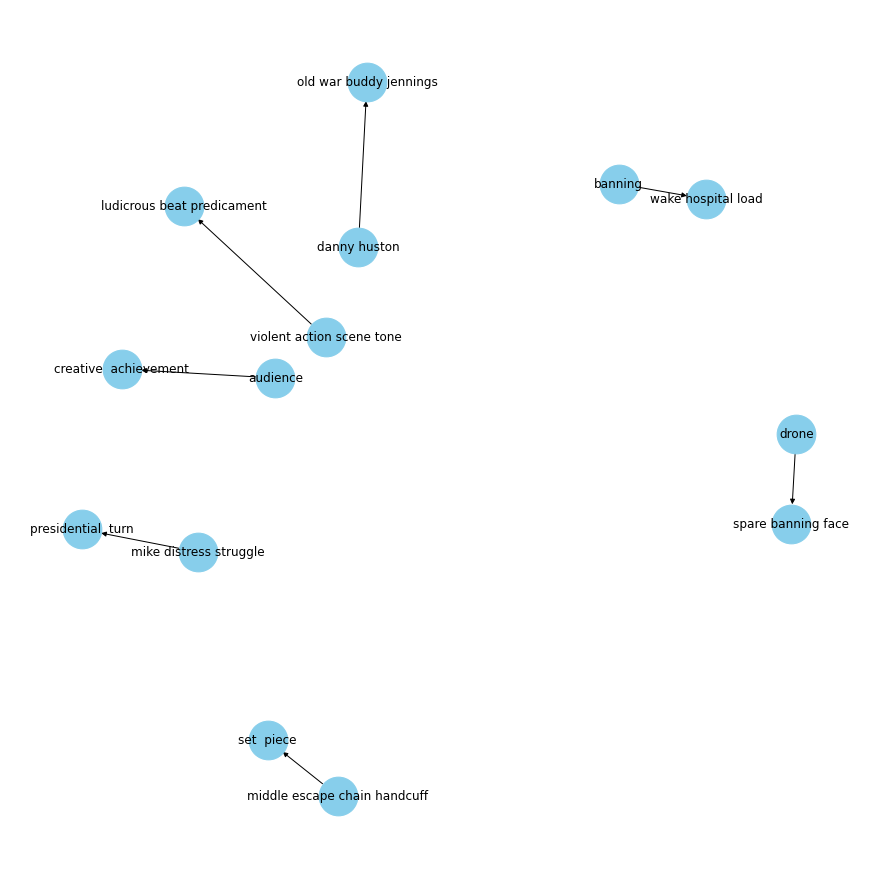

In [ ]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [ ]:
ENTITY_TO_EXPLORE = 'angel'

In [ ]:
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

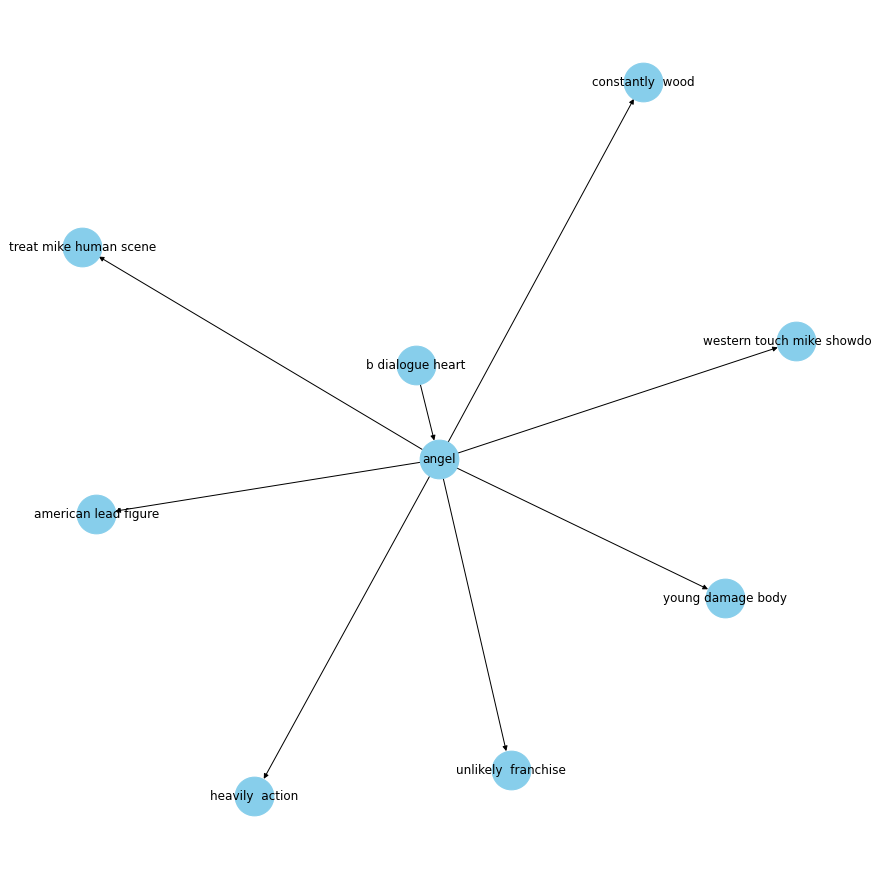

In [ ]:
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [ ]:
MOVIE_TO_EXPLORE = 'Angel Has Fallen'

In [ ]:
movie_reviews = (corpus_df.loc[corpus_df['Movie Title'] == MOVIE_TO_EXPLORE, 'Text']
                             .reset_index(drop=True))

In [ ]:
movie_reviews

0    The sleepy, dopey action bonanza  Angel Has Fa...
1     Angel Has Fallen  marks the third time that G...
2    In 2013 audiences were first introduced to Sec...
3    Ever heard of the phrase  a glutton for punish...
4    And here is part three of the  Fallen  trilogy...
5    American movie presidents can only make us wis...
6    It wouldn t take much for  Angel Has Fallen  t...
7    Angel Has Fallen is what used to be called a B...
8    Though some critics have given the  Fallen  mo...
9    Director and co-writer Ric Roman Waugh not onl...
Name: Text, dtype: object

In [ ]:
movie_reviews[1]

' Angel Has Fallen  marks the third time that Gerard Butler, as the Secret Service agent and scowling samurai cowboy Mike Banning, has had to rescue the President of the United States from an international conspiracy so cuckoo bananas that the movie barely expects you to believe it. (Actually, in the six years since this series launched, the bar for what people will believe has been lowered. For all I know, fans of the  Fallen  films think they re based on true stories.) In  Olympus Has Fallen  (2013) and  London Has Fallen  (2016), the president was portrayed by Aaron Eckhart, who came off like a testy press secretary from the  West Wing  days. (Eckhart is a good actor with a terse appealing manner, but he s not exactly presidential.) In  Angel Has Fallen,  the role of Leader of the Free World reverts back to Morgan Freeman, who has played it approximately 47 times   or, at least, it feels that way. Seeing him back in the Oval Office is as comfy and reassuring as slipping into a daydr

In [ ]:
doc = nlp(movie_reviews[1])

In [ ]:
list(doc.sents)

[ Angel Has Fallen  marks the third time that Gerard Butler, as the Secret Service agent and scowling samurai cowboy Mike Banning, has had to rescue the President of the United States from an international conspiracy so cuckoo bananas that the movie barely expects you to believe it.,
 (Actually, in the six years since this series launched, the bar for what people will believe has been lowered.,
 For all I know, fans of the  Fallen  films think they re based on true stories.),
 In  Olympus Has Fallen  (2013) and  London Has Fallen  (2016), the president was portrayed by Aaron Eckhart, who came off like a testy press secretary from the  West Wing  days.,
 (Eckhart is a good actor with a terse appealing manner, but he s not exactly presidential.),
 In  Angel Has Fallen,  the role of Leader of the Free World reverts back to Morgan Freeman, who has played it approximately 47 times   or, at least, it feels that way.,
 Seeing him back in the Oval Office is as comfy and reassuring as slipping 

In [ ]:
doc_sents = [str(x) for x in list(doc.sents)]

In [ ]:
example_sent = doc_sents[0]

In [ ]:
example_sent

' Angel Has Fallen  marks the third time that Gerard Butler, as the Secret Service agent and scowling samurai cowboy Mike Banning, has had to rescue the President of the United States from an international conspiracy so cuckoo bananas that the movie barely expects you to believe it.'

In [ ]:
get_subject_verb_object(example_sent)

['Fallen', 'marks', 'time']

In [ ]:
example_nlp = nlp(example_sent)

In [ ]:
for tok in example_nlp:
  print(tok.dep_)

dep
nsubj
aux
nsubj
dep
ROOT
det
amod
dobj
dobj
compound
nsubj
punct
prep
det
compound
compound
pobj
cc
amod
compound
compound
compound
conj
punct
aux
relcl
aux
xcomp
det
dobj
prep
det
compound
pobj
prep
det
amod
pobj
advmod
acl
dobj
dobj
det
nsubj
advmod
relcl
nsubj
aux
ccomp
dobj
punct


In [ ]:
spacy.explain('punct')

'punctuation'

In [ ]:
get_entities(example_sent)

['barely  you', 'it']

In [ ]:
get_relation(example_sent)

'marks'

In [ ]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 39/39 [00:01<00:00, 25.90it/s]


In [ ]:
entity_pairs

[['barely  you', 'it'],
 ['people', 'what'],
 ['Fallen  they', 'true  stories'],
 ['Aaron who', 'West Wing days'],
 ['appealing  he', 'appealing  manner'],
 ['least  it', 'it'],
 ['where Barack Obama', 'as Oval daydream'],
 ['secretly  anyone', 'Piper him'],
 ['Secret it', 'Secret Service'],
 ['how  he', 'one'],
 ['comic strip that', 'Fallen  series'],
 ['when  you', 'big budget B movie'],
 ['what', 'black  birds'],
 ['low  explosions', 'surgical  precision'],
 ['18 Secret Service agents', 'shore'],
 ['', ''],
 ['drones', 'purposefully  him'],
 ['president', 'D.C.  hospital'],
 ['him', 'bad  guys'],
 ['guardian angel', 'entertaining  ways'],
 ['crazy war you', 'grizzled West Virginia Unabomber'],
 ['they', 'life'],
 ['we', 'Angel'],
 ['unending control he', 'home'],
 ['he', 'army'],
 ['predicament', 'existence'],
 ['yet  that', 'souled neo Bronson'],
 ['It', 'process'],
 ['assault rifle assault combat', 'assault rifle assault rifle'],
 ['whole  thing', 'generic Bourne knockoff'],
 ['pr

In [ ]:

relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 39/39 [00:00<00:00, 40.31it/s]


In [ ]:

relations

['marks',
 'lowered',
 'think',
 'portrayed by',
 'is',
 'feels',
 'is',
 'getting on',
 's in',
 'tells',
 's',
 's good',
 'is',
 'are',
 'are',
 'Mike',
 's alive',
 'pulls',
 'escapes',
 'is out',
 'check',
 's',
 'is',
 'applauded after',
 'looks',
 'justified',
 'becomes',
 'reduces',
 'is',
 'plays like',
 'is',
 's',
 'watching',
 'place',
 'played by',
 's at',
 'trailing',
 'stretches',
 's bad']

In [ ]:

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 
                      'target': target, 
                      'edge': relations})

In [ ]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

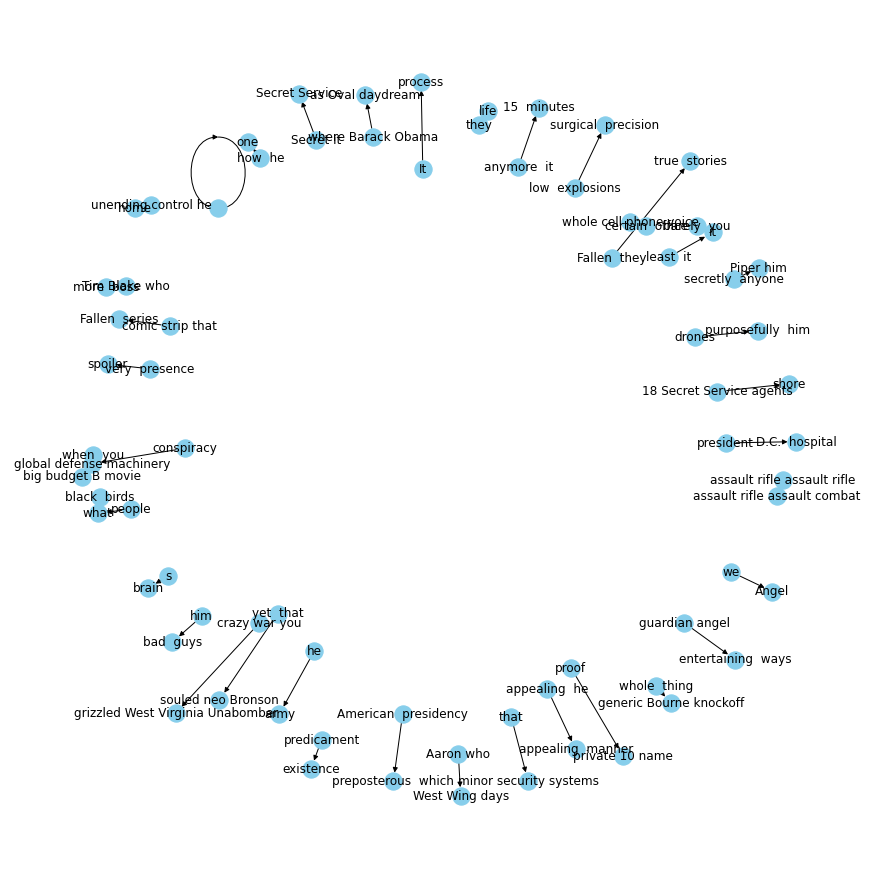

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [67]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen,KLD_Doc4_AngelHasFallen
Text,"The sleepy, dopey action bonanza Angel Has Fa...",Angel Has Fallen marks the third time that G...,In 2013 audiences were first introduced to Sec...,Ever heard of the phrase a glutton for punish...
Submission File Name,KLD_Doc1_AngelHasFallen,KLD_Doc2_AngelHasFallen,KLD_Doc3_AngelHasFallen,KLD_Doc4_AngelHasFallen
Student Name,KLD,KLD,KLD,KLD
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_60,Action_Angel Has Fallen_N_61,Action_Angel Has Fallen_N_62,Action_Angel Has Fallen_N_63
Doc_ID,60,61,62,63
raw_sentences,"[The sleepy, dopey action bonanza Angel Has F...",[ Angel Has Fallen marks the third time that ...,[In 2013 audiences were first introduced to Se...,[Ever heard of the phrase a glutton for punis...


In [68]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet 

In [69]:
data = datafull[['Text','Genre of Movie']].copy()

In [70]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

## Review Examples by Genre

In [71]:
features, targets = data['Text'], data['Genre of Movie code']                                                                         
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      60
Comedy          1                      50
Sci-Fi          3                      50
Horror          2                      40
dtype: int64

## Create Datasets for Model Development

### Cell 10 - def get_dataset_partitions_pd

In [72]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [73]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [74]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [75]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [77]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [78]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [79]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'film', 's', 'i', 'movie', 'one', 'like', 'it',
       'character', 'time', 'get', 'nt', 'but', 'even', 'make', 'much',
       'way', 'scene'], dtype='<U18')

In [80]:
vocab[-20:]

array(['understands', 'underpinnings', 'uncredited', 'uncovers',
       'uncover', 'uncommon', 'unavoidable', 'unabashedly',
       'ultraviolent', 'ubach', 'typecast', 'tying', 'twopage', 'twelve',
       'tweak', 'twaddle', 'turmoil', 'turkey', 'turan', 'truthfully'],
      dtype='<U18')

## Example of Encoded Words

In [81]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  206,    1,  699, 3739,    1,  142,  142])

In [82]:
len(encoder.get_vocabulary())

5000

In [83]:
encoder(data['Text'][0])

<tf.Tensor: shape=(452,), dtype=int64, numpy=
array([   2, 3940,    1,   25,    1,  239,  183,  126, 2489,  272,   65,
        639, 3014,  327,  553, 1148,  183,  126,  239,  183,  126,   15,
        356, 3018,  457, 1148,  183,  126, 4692,    1, 1998, 1593,    1,
          1,    1, 1207,  599,    1, 2967,  770, 1587,  292, 1204, 1004,
          1,    1, 1995,    1,    1,    1,    1,  201,  696,  752,  560,
         73, 2042,   63, 3153,    1, 1148,  183,  126,  161, 2954, 3137,
       2211,  105,   31,    6, 1004, 3868,  104,  134, 1524, 3325,    1,
        201, 3115, 3986, 2492,    1,  157,    1,    1,  140, 2135,  348,
       2450,    1, 1404,    1,    1,  259, 4576, 1593,    1,   82, 2355,
          1,   78,  165,  295, 1348,   72,  149,   98,    1,    1,    8,
       1593, 4279,    1, 1251,  202,    1, 1593, 4279,  165, 3115, 3057,
        208, 1255,    8,  233,  149, 1148,  183,  126,   38,    6,    5,
        461,  291,  999, 2503,    5,  882,  461,  291,  239,  183,  126,
     

In [84]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"What dumb , fun , curiously adolescent movie . The premise straight 13-year-old 's creative writing book : `` What , like , futuristic world , right , `` feeling `` illegal ! `` Yep , 's stupid . But surrender inherent idiocy 's entertainment . The dystopian setting Libria - concrete jungle fascistic government maintains peace eliminating anger , sorrow , joy , love destroying art literature issuing regular dos suppressant called Prozium ( hang , sound bit like ... Prozac ! Genius ) . Chief among state enforcer cleric John Preston ( Christian Bale ) - highly-trained drone , prone shooting anyone show slightest sign happiness , sadness , etc . God help read poetry . If 're shot , `` sense offender `` sent incinerated - fate befell Preston 's wife year , deadened dedicated care . When fall Emily Watson 's feisty rebel , however , finally start see sense ( badaboom ! ) considers joining resistance ... So , repressive future world man rise zero hero help chic black clothing big 

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [125]:
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [126]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [127]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 177s 3s/step - loss: 1.3710 - accuracy: 0.2704 - val_loss: 2.0373 - val_accuracy: 0.1111
Epoch 2/200
53/53 [==============================] - 140s 3s/step - loss: 1.1343 - accuracy: 0.4906 - val_loss: 1.4663 - val_accuracy: 0.3333
Epoch 3/200
53/53 [==============================] - 147s 3s/step - loss: 0.9419 - accuracy: 0.6038 - val_loss: 1.2469 - val_accuracy: 0.4444
Epoch 4/200
53/53 [==============================] - 139s 3s/step - loss: 0.5769 - accuracy: 0.7736 - val_loss: 1.8380 - val_accuracy: 0.4444
Epoch 5/200
53/53 [==============================] - 148s 3s/step - loss: 0.3345 - accuracy: 0.8805 - val_loss: 1.2178 - val_accuracy: 0.5556
Epoch 6/200
53/53 [==============================] - 138s 3s/step - loss: 0.2108 - accuracy: 0.9182 - val_loss: 0.6331 - val_accuracy: 0.8889
Epoch 7/200
53/53 [==============================] - 149s 3s/step - loss: 0.3023 - accuracy: 0.8994 - val_loss: 1.4598 - val_accuracy: 0.5556
Epoch 

## Model Performance Test Accuracy

In [128]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 2s 286ms/step - loss: 2.6487 - accuracy: 0.3889
Test Loss: 2.6486713886260986
Test Accuracy: 0.3888888955116272


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [129]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [130]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.577,0.774,1.838,0.444
4,0.335,0.881,1.218,0.556
5,0.211,0.918,0.633,0.889
6,0.302,0.899,1.460,0.556
7,0.117,0.950,0.401,0.889


In [131]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

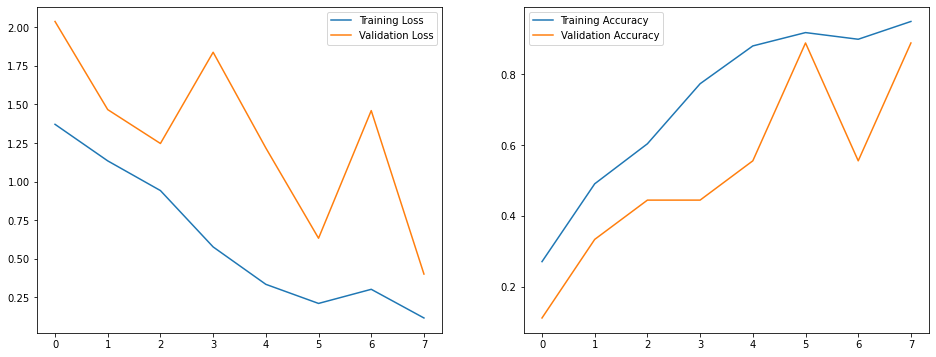

In [132]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [133]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 10s 503ms/step


In [134]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

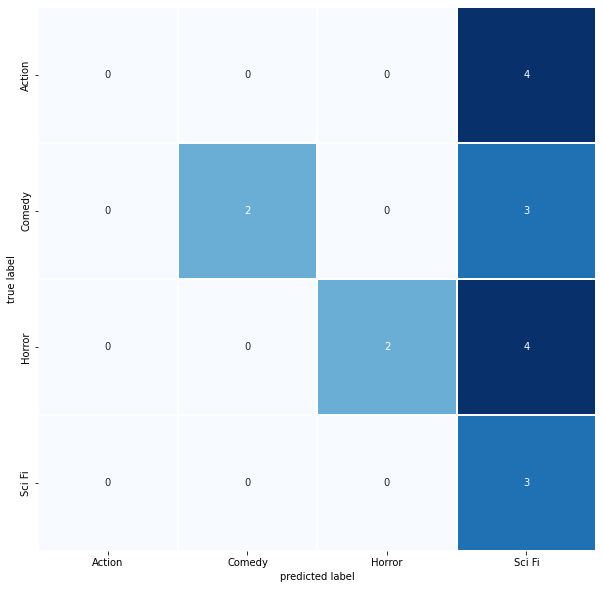

In [135]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [136]:
preds3 = model.predict(train_ds)
y_pred3 = np.argmax(preds3, axis=1)
y3 = np.concatenate([y for x, y in train_ds], axis=0)

53/53 [==============================] - 17s 316ms/step


In [137]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

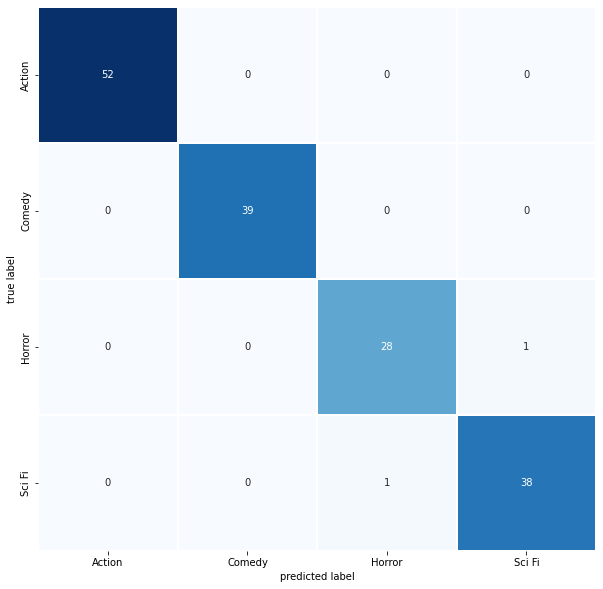

In [138]:
plot_confusion_matrix_labeled(y3,y_pred3, CLASSES_LIST=CLASSES_LIST)

In [139]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [140]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.05%,0.03%,0.10%,11.86%,0.28%,29.26%,2.00%,0.04%,0.00%,0.06%,0.02%,0.08%,0.01%,0.33%,0.99%
Comedy,1.42%,0.12%,2.17%,18.07%,1.18%,6.33%,2.87%,0.21%,0.01%,1.09%,0.08%,0.59%,0.02%,1.69%,19.80%
Horror,0.87%,12.29%,6.93%,0.97%,0.78%,0.63%,0.89%,6.67%,93.80%,1.19%,40.32%,0.94%,85.63%,0.91%,1.00%
Sci Fi,97.66%,87.56%,90.80%,69.10%,97.76%,63.79%,94.24%,93.08%,6.19%,97.67%,59.58%,98.39%,14.34%,97.07%,78.22%


## RNN Model Architecture

In [141]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        197632    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                      

In [142]:
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.40      0.57         5
           2       1.00      0.33      0.50         6
           3       0.21      1.00      0.35         3

    accuracy                           0.39        18
   macro avg       0.55      0.43      0.36        18
weighted avg       0.65      0.39      0.38        18



**Model for Sentiment Analysis**

In [220]:
data = datafull[['Text','Review Type (pos or neg)']].copy()

In [221]:
data['Review Type (pos or neg)'] = data['Review Type (pos or neg)'].astype("category")
data['Review Type (pos or neg) code'] = data['Review Type (pos or neg)'].cat.codes
data['Review Type (pos or neg) code'].tail().T

195    1
196    1
197    1
198    1
199    1
Name: Review Type (pos or neg) code, dtype: int8

In [222]:
features, targets = data['Text'], data['Review Type (pos or neg) code']                                                                         
data[["Review Type (pos or neg)","Review Type (pos or neg) code"]].value_counts()

Review Type (pos or neg)  Review Type (pos or neg) code
Negative                  0                                100
Positive                  1                                100
dtype: int64

In [223]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Review Type (pos or neg) code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

In [224]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Review Type (pos or neg) code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Review Type (pos or neg) code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Review Type (pos or neg) code'].values, tf.int64),
)

In [225]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

In [226]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Text                           200 non-null    object  
 1   Review Type (pos or neg)       200 non-null    category
 2   Review Type (pos or neg) code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.2+ KB


In [228]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [229]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [230]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'film', 's', 'i', 'movie', 'one', 'like', 'it',
       'character', 'time', 'get', 'nt', 'but', 'even', 'make', 'much',
       'way', 'scene'], dtype='<U18')

In [231]:
vocab[-20:]

array(['turkey', 'turan', 'truthfully', 'trusting', 'trudging', 'tropey',
       'triumphantly', 'trimmed', 'trim', 'trickle', 'tribe', 'trial',
       'tremendously', 'treated', 'traveling', 'trashy', 'transport',
       'translating', 'transgressiveness', 'transgression'], dtype='<U18')

In [232]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  210,    1,  736, 3725,    1,  140,  140])

In [233]:
len(encoder.get_vocabulary())

5000

In [234]:
encoder(data['Text'][0])

<tf.Tensor: shape=(452,), dtype=int64, numpy=
array([   2, 3927,    1,   25,    1,  238,  181,  125, 2480,  270,   64,
        606, 3011,  327,  555, 1136,  181,  125,  238,  181,  125,   15,
        361, 3015,  457, 1136,  181,  125, 4675,    1, 1986, 1779,    1,
          1,    1, 1203,  626,    1, 2962,  768, 1577,  299, 1201, 1095,
          1,    1, 1984,    1,    1,    1,    1,  202,  691,  751,  560,
         69, 2032,   61, 3152,    1, 1136,  181,  125,  161, 3594, 3137,
       2200,  105,   31,    6, 1095,    1,  104,  135, 1514, 3320,    1,
        202, 3115, 3974, 2484,    1,  159,    1,    1,  144, 2121,  352,
       2444,    1, 1391,    1,    1,  248, 4562, 1779,    1,   84, 2345,
          1,   78,  171,  293, 1335,   72,  146,   99,    1,    1,    8,
       1779, 4265,    1, 1389,  203,    1, 1779, 4265,  171, 3115, 3059,
        216, 1248,    8,  231,  146, 1136,  181,  125,   37,    6,    5,
        461,  290,  994, 2496,    5,  880,  461,  290,  238,  181,  125,
     

In [235]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'Stephen King took 1,138 page tell story It , 1986 horror classic evil clown called Pennywise torment group child Maine . But director Andy Muschietti always seems pressed time , 2017 adaptation first quarter It far expansive sequel , run nearly three hour . It Chapter Two much grander project first film , encompasses main character child adult . The main problem initial movie Bill Skarsg rd Pennywise much special effect little taunting evil human clown makeup , It Chapter Two , Skarsg rd allowed make much contribution . The second half 1990 TV miniseries It , dealt child character adult , much weaker first ; It Chapter Two stronger predecessor , partly adult actor give much emotional intensity , particularly James McAvoy grown-up Bill Denbrough Jessica Chastain adult Beverly . It also impressive Muschietti focus intimate psychological horror le spectacle . Some upsetting thing happen first hour It Chapter Two , none brutal gay-bashing murder defiant Adrian Mellon ( Xavier Do

In [236]:
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.5))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.5))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [237]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [238]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 108s 2s/step - loss: 0.8833 - accuracy: 0.4654 - val_loss: 0.7370 - val_accuracy: 0.3333
Epoch 2/200
53/53 [==============================] - 89s 2s/step - loss: 0.7211 - accuracy: 0.5094 - val_loss: 0.7287 - val_accuracy: 0.4444
Epoch 3/200
53/53 [==============================] - 83s 2s/step - loss: 0.6932 - accuracy: 0.5472 - val_loss: 0.7392 - val_accuracy: 0.3333
Epoch 4/200
53/53 [==============================] - 84s 2s/step - loss: 0.3679 - accuracy: 0.8239 - val_loss: 1.3879 - val_accuracy: 0.3333
CPU times: user 11min 8s, sys: 3.82 s, total: 11min 12s
Wall time: 7min 47s


In [239]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 214ms/step - loss: 1.2498 - accuracy: 0.5556
Test Loss: 1.2498048543930054
Test Accuracy: 0.5555555820465088


In [240]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [241]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.883,0.465,0.737,0.333
1,0.721,0.509,0.729,0.444
2,0.693,0.547,0.739,0.333
3,0.368,0.824,1.388,0.333


In [242]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

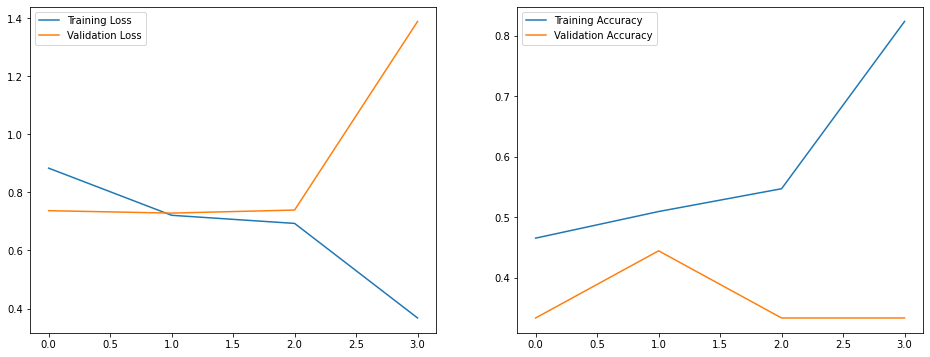

In [243]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [244]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 8s 210ms/step


In [245]:
CLASSES_LIST = ['Negative','Positive']

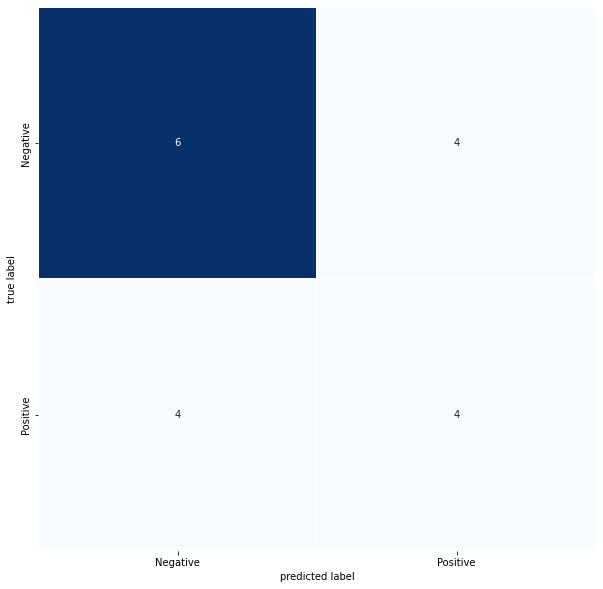

In [246]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [247]:
preds3 = model.predict(train_ds)
y_pred3 = np.argmax(preds3, axis=1)
y3 = np.concatenate([y for x, y in train_ds], axis=0)

53/53 [==============================] - 11s 215ms/step


In [248]:
CLASSES_LIST = ['Negative','Positive']

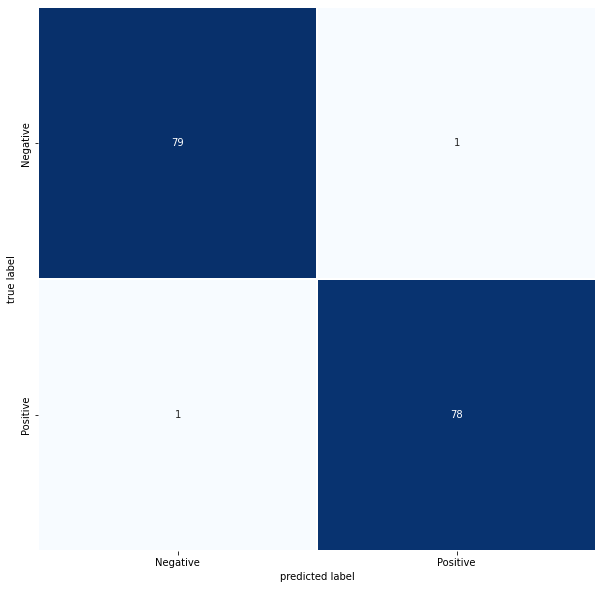

In [249]:
plot_confusion_matrix_labeled(y3,y_pred3, CLASSES_LIST=CLASSES_LIST)

In [65]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [250]:
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.50      0.50      0.50         8

    accuracy                           0.56        18
   macro avg       0.55      0.55      0.55        18
weighted avg       0.56      0.56      0.56        18

